In [8]:
# ================================================================
# 🎓 DIPLOMA PROJECT: Sales Forecasting with ML + Hyperparameter Tuning
# ================================================================

# 📦 LIBRARIES
import pandas as pd
import numpy as np
import time
import shap
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor



In [7]:
!pip install optuna
!pip install seaborn
!pip install lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s  0:00:00

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [11]:
# ================================================================
# 1️⃣ LOAD AND PREPARE DATA
# ================================================================
train_path = "/Users/volodymyrchub/Project/ROSSMANN/train.csv"
store_path = "/Users/volodymyrchub/Project/ROSSMANN/store.csv"


print("Loading data...")
train = pd.read_csv(train_path)
store = pd.read_csv(store_path)
df = pd.merge(train, store, on="Store", how="left")


df = df[df["Open"] == 1]


# Date features
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)


# Fill missing values
df.fillna(0, inplace=True)


# Features and target
target = "Sales"
X = df.drop(columns=[target, "Date", "Customers", "Open"])
y = df[target]


# ✅ Fix mixed types before encoding
for col in X.columns:
    if X[col].dtype == 'object' or X[col].apply(lambda v: isinstance(v, str)).any():
        X[col] = X[col].fillna("missing").astype(str)

# Encode categorical
for col in X.select_dtypes("object"):
    X[col] = LabelEncoder().fit_transform(X[col])


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Loading data...


/var/folders/_g/qck5cx5j5bbgjqbzx31cshl40000gn/T/ipykernel_60202/2601864304.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(train_path)


In [13]:
# ================================================================
# 2️⃣ DEFINE METRICS
# ================================================================
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


def evaluate_model(name, model, X_test, y_test, start_time):
    y_pred = model.predict(X_test)
    end_time = time.time()
    return {
"Model": name,
"MAE": mean_absolute_error(y_test, y_pred),
"RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
"WAPE": wape(y_test, y_pred),
"sMAPE": smape(y_test, y_pred),
"Time (s)": round(end_time - start_time, 2)
}, y_pred

In [14]:
# ================================================================
# 3️⃣ BASE MODELS
# ================================================================
models = {
    "XGBoost": XGBRegressor(
        random_state=42, n_estimators=300, learning_rate=0.1, max_depth=6
    ),
    "CatBoost": CatBoostRegressor(
        random_seed=42, iterations=300, learning_rate=0.1, depth=6, verbose=0
    ),
    "RandomForest": RandomForestRegressor(
        random_state=42, n_estimators=300, max_depth=10
    ),
}

results_list = []
for name, model in models.items():
    print(f"Training {name}...")
    start = time.time()
    model.fit(X_train_scaled, y_train)
    result, _ = evaluate_model(name, model, X_test_scaled, y_test, start)
    results_list.append(result)



Training XGBoost...
Training CatBoost...
Training RandomForest...


In [15]:
# ================================================================
# 4️⃣ HYPERPARAMETER TUNING
# ================================================================
print("🔍 Grid Search for RandomForest...")
rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [10, 15],
    "min_samples_split": [2, 5],
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
print("Best RF Params:", grid_rf.best_params_)

print("🔍 Bayesian Optimization for CatBoost...")


def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "iterations": trial.suggest_int("iterations", 200, 800),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
    }
    model = CatBoostRegressor(**params, random_seed=42, verbose=0)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return np.sqrt(mean_squared_error(y_test, preds))


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

best_params_cat = study.best_params
print("Best CatBoost Params:", best_params_cat)

best_cat = CatBoostRegressor(**best_params_cat, random_seed=42, verbose=0)
best_cat.fit(X_train_scaled, y_train)

for name, model in [("RF (Tuned)", best_rf), ("CatBoost (Tuned)", best_cat)]:
    start = time.time()
    result, _ = evaluate_model(name, model, X_test_scaled, y_test, start)
    results_list.append(result)



🔍 Grid Search for RandomForest...


[I 2025-10-26 18:06:26,305] A new study created in memory with name: no-name-2519c794-7fcd-43a8-84c7-b15f8d802a7a


Best RF Params: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 400}
🔍 Bayesian Optimization for CatBoost...


[I 2025-10-26 18:06:30,934] Trial 0 finished with value: 2058.274486644765 and parameters: {'depth': 5, 'learning_rate': 0.0976202384233657, 'iterations': 203, 'l2_leaf_reg': 9.158493393962171}. Best is trial 0 with value: 2058.274486644765.
[I 2025-10-26 18:06:49,190] Trial 1 finished with value: 1330.7929431233313 and parameters: {'depth': 5, 'learning_rate': 0.17145316195434304, 'iterations': 752, 'l2_leaf_reg': 8.989854176495925}. Best is trial 1 with value: 1330.7929431233313.
[I 2025-10-26 18:07:35,899] Trial 2 finished with value: 1593.972331113448 and parameters: {'depth': 10, 'learning_rate': 0.01590175490506241, 'iterations': 731, 'l2_leaf_reg': 6.86470210843167}. Best is trial 1 with value: 1330.7929431233313.
[I 2025-10-26 18:07:51,896] Trial 3 finished with value: 1214.8781043073254 and parameters: {'depth': 9, 'learning_rate': 0.11354222769080179, 'iterations': 431, 'l2_leaf_reg': 0.08881148395722122}. Best is trial 3 with value: 1214.8781043073254.
[I 2025-10-26 18:08:42

Best CatBoost Params: {'depth': 10, 'learning_rate': 0.15709260449254298, 'iterations': 595, 'l2_leaf_reg': 1.730782105373773}


In [16]:
# ================================================================
# 5️⃣ ENSEMBLES
# ================================================================
print("Building ensemble models...")
cat = best_cat
lgb = LGBMRegressor(random_state=42, n_estimators=300, learning_rate=0.05)
enet = ElasticNet(alpha=0.001, l1_ratio=0.5)

cat.fit(X_train_scaled, y_train)
lgb.fit(X_train_scaled, y_train)
enet.fit(X_train_scaled, y_train)

pred_cat = cat.predict(X_test_scaled)
pred_lgb = lgb.predict(X_test_scaled)
pred_enet = enet.predict(X_test_scaled)

weights = [0.5, 0.3, 0.2]
pred_weighted = weights[0] * pred_cat + weights[1] * pred_lgb + weights[2] * pred_enet

ensemble_weighted = {
    "Model": "Weighted Ensemble",
    "MAE": mean_absolute_error(y_test, pred_weighted),
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_weighted)),
    "WAPE": wape(y_test, pred_weighted),
    "sMAPE": smape(y_test, pred_weighted),
    "Time (s)": None,
}
results_list.append(ensemble_weighted)

stack_train = np.column_stack(
    [
        cat.predict(X_train_scaled),
        lgb.predict(X_train_scaled),
        enet.predict(X_train_scaled),
    ]
)
stack_test = np.column_stack([pred_cat, pred_lgb, pred_enet])

meta_model = LinearRegression()
meta_model.fit(stack_train, y_train)
pred_stack = meta_model.predict(stack_test)

ensemble_stacked = {
    "Model": "Stacked Ensemble",
    "MAE": mean_absolute_error(y_test, pred_stack),
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_stack)),
    "WAPE": wape(y_test, pred_stack),
    "sMAPE": smape(y_test, pred_stack),
    "Time (s)": None,
}
results_list.append(ensemble_stacked)



Building ensemble models...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 675513, number of used features: 18
[LightGBM] [Info] Start training from score 7019.942620


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e+12, tolerance: 6.601e+08
  model = cd_fast.enet_coordinate_descent(


Running SHAP analysis...


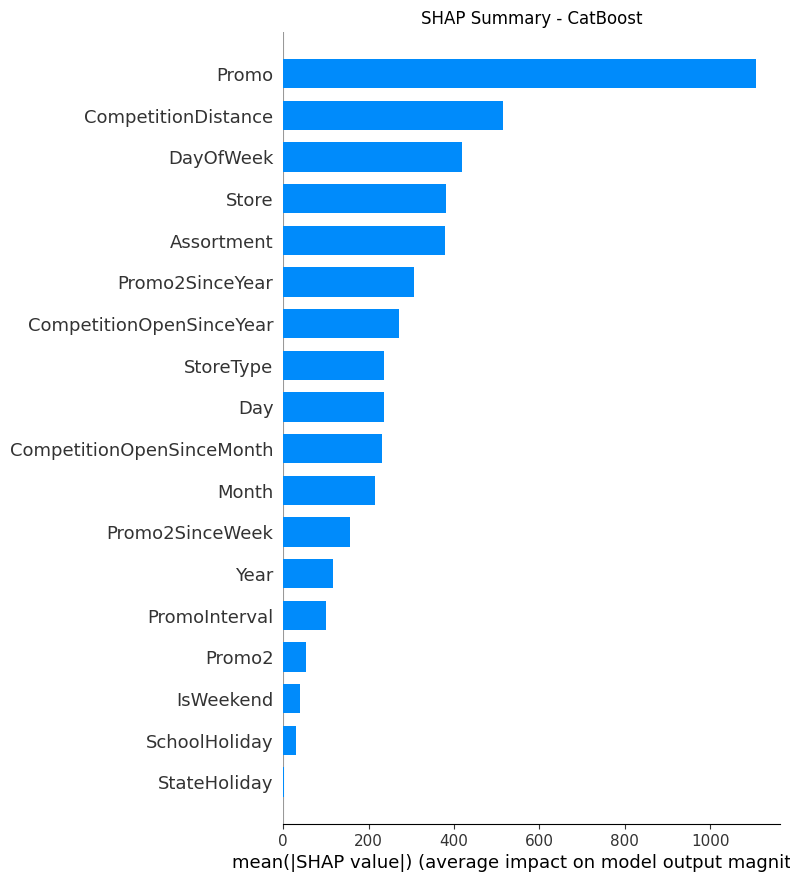

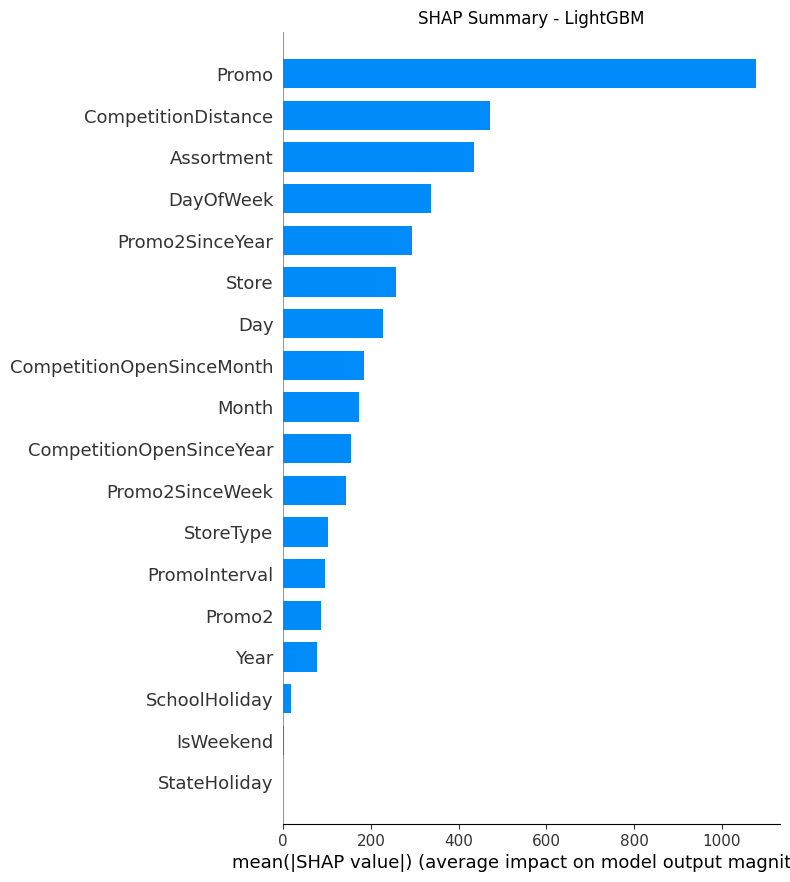

In [17]:
# ================================================================
# 6️⃣ SHAP ANALYSIS
# ================================================================
print("Running SHAP analysis...")
explainer_cat = shap.TreeExplainer(best_cat)
shap_values_cat = explainer_cat.shap_values(X_test_scaled)
shap.summary_plot(shap_values_cat, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary - CatBoost")
plt.show()

explainer_lgb = shap.TreeExplainer(lgb)
shap_values_lgb = explainer_lgb.shap_values(X_test_scaled)
shap.summary_plot(shap_values_lgb, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary - LightGBM")
plt.show()




📊 Model Results:
               Model          MAE         RMSE      WAPE      sMAPE  Time (s)
0            XGBoost   909.150584  1256.074698  0.135739  14.327449      3.12
1           CatBoost  1263.543896  1699.818677  0.188651  19.612398      7.78
2       RandomForest  1633.071620  2211.255530  0.243822  24.885463    305.49
3         RF (Tuned)  1084.813765  1489.275075  0.161966  17.038687      4.38
4   CatBoost (Tuned)   845.181352  1167.782192  0.126188  13.139433      0.05
5  Weighted Ensemble  1016.885903  1386.322154  0.151824  16.093847       NaN
6   Stacked Ensemble   863.190274  1191.305560  0.128877  13.399645       NaN


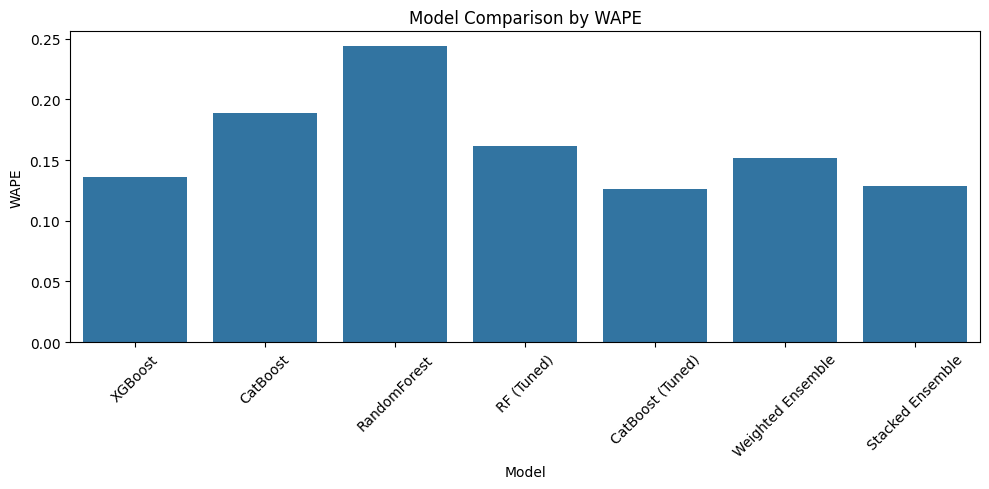

In [18]:
# ================================================================
# 7️⃣ RESULTS TABLE & VISUALIZATION
# ================================================================
results_df = pd.DataFrame(results_list)
print("\n📊 Model Results:")
print(results_df)

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="WAPE", data=results_df)
plt.title("Model Comparison by WAPE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [19]:
# ================================================================
# 8️⃣ FINAL SUMMARY
# ================================================================
print("\n✅ Best Parameters:")
print("RandomForest:", grid_rf.best_params_)
print("CatBoost:", best_params_cat)
print("\n📈 Best model by WAPE:", results_df.loc[results_df["WAPE"].idxmin(), "Model"])


✅ Best Parameters:
RandomForest: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 400}
CatBoost: {'depth': 10, 'learning_rate': 0.15709260449254298, 'iterations': 595, 'l2_leaf_reg': 1.730782105373773}

📈 Best model by WAPE: CatBoost (Tuned)
